# Link Analysis

# Table of Content

- [Setup](#setup)
- [Hits](#hits)
- [PageRank](#pagerank)
- [SimRank](#simrank)
- [Result Analysis and Discussion](#result)
- [Computation Performance Analysis](#performance)

---
# <a name='setup'></a> Setup

In [1]:
%matplotlib inline
%load_ext memory_profiler

In [2]:
from collections import namedtuple
from copy import deepcopy
from pprint import PrettyPrinter

import numpy as np
import networkx as nx
from networkx.exception import NetworkXError
import matplotlib.pyplot as plt

In [3]:
pp = PrettyPrinter(indent=4)

## Load Data

In [4]:
Edge = namedtuple('Edge', ('source', 'dest'))

In [5]:
def load_graph_gen(filename):
    with open(filename, 'r') as input_file:
        for line in input_file:
            source, dest = line.strip().split(',')
            yield Edge(source, dest)

In [6]:
file_name_template = 'dataset/graph_{num}.txt'

graphs = list()
for i in range(1, 7):
    filename = file_name_template.format(num=i)
    graph_gen = load_graph_gen(filename)
    graphs.append(nx.DiGraph(graph_gen))

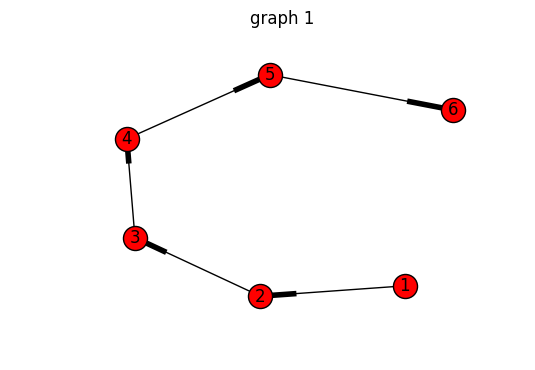

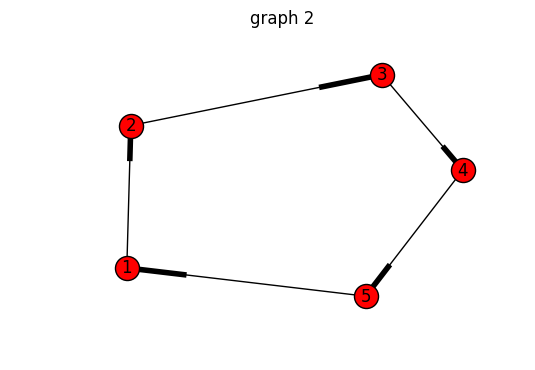

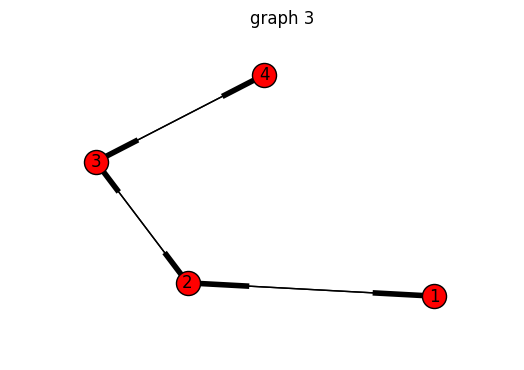

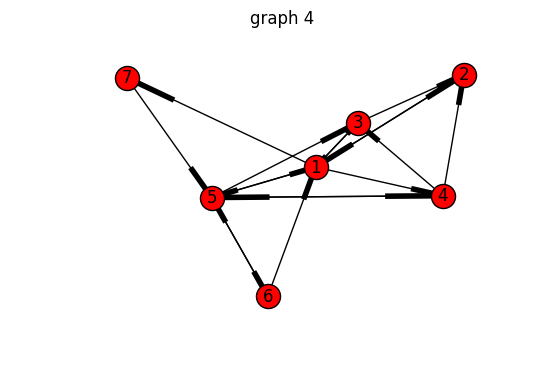

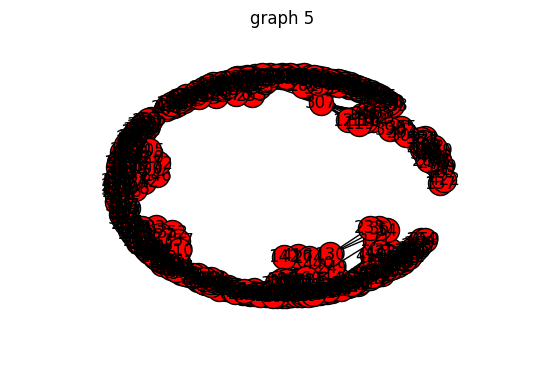

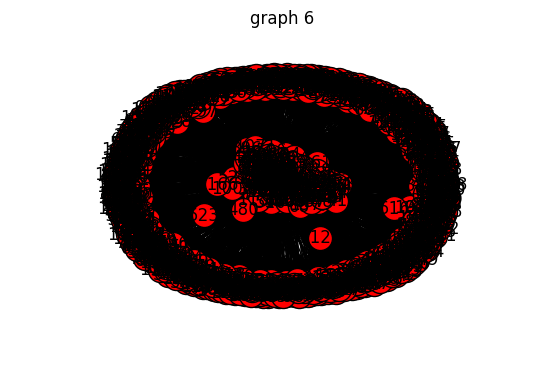

In [7]:
# Visualize  graphs
for index, graph in enumerate(graphs, 1):
    plt.figure(index)
    plt.title('graph {index}'.format(index=index))
    nx.draw(graph, arrows=True, with_labels=True)

In [8]:
G2 = nx.DiGraph()
G2.add_edges_from([(1,3),(2,3),(3,4),(4,1)])

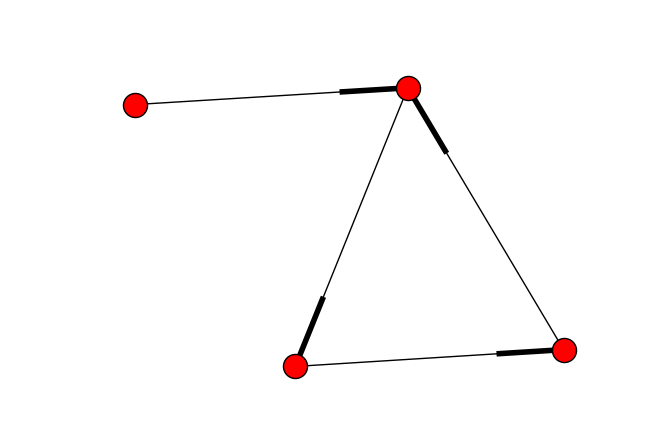

In [9]:
nx.draw(G2)
plt.show()

---
# <a name='hits'></a> Hits

## self implement of HITS (1)

In [12]:
def initGraph(G):
    for node in G:
        G.add_node(node, authority=1)
        G.add_node(node, hub=1)
    return G

In [13]:
def normalized(G, h, a):
    totalH, totalA, t = 0, 0, 0
    for node in G:
        totalH += h[node]
        totalA += a[node]
    for node in G:
        #t += abs(h[node] / totalH - G.node[node]['hub'])
        t += abs(a[node] / totalA - G.node[node]['authority'])
        G.node[node]['hub'] = h[node] / totalH
        G.node[node]['authority'] = a[node] / totalA
    return G,t

In [14]:
def authorityHub(G, h, a):
    for node in G:
        h[node], a[node] = 0,0
        for ch in G.successors(node):
            h[node] += G.node[ch]['authority']
        for pa in G.predecessors(node):
            a[node] += G.node[pa]['hub']
    G,t = normalized(G,h,a)
    return G,h,a,t

In [15]:
def HITS(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    h, a = {}, {}
    initGraph(G)
    it, t = 0, 1
    while it < max_iter and t > tol:
        G,h,a,t = authorityHub(G,h,a)
        print(it,t)
        it += 1
    for node in G:
        h[node] = G.node[node]['hub']
        a[node] = G.node[node]['authority']        
    return h,a

## self implement of HITS (2)

In [16]:
def maximal(m):
    #total = np.sqrt(np.sum(np.square(np.abs(m))))
    maximum = np.max(np.abs(m))
    return m/maximum #total

In [17]:
def normal(m):
    total = np.sum(np.abs(m))
    return m/total

In [18]:
def compare(m1, m2):
    result = np.sum(np.abs(m1-m2))
    return result

In [19]:
def hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    k = G.number_of_nodes()
    nodeDict, Hub, Auth = {}, {}, {}
    i, it, t = 0, 0, 1
    for node in G:
        nodeDict[node] = i
        i += 1
        
    A = np.zeros((k, k))
    for node in G:    
        for n in G.neighbors(node):
            A[nodeDict[node]][nodeDict[n]] = 1
    A.shape=(k,k)  
    AT = np.transpose(A)
    
    h = np.ones((k,1))/k
    a = np.ones((k,1))/k 
    
    while it <= max_iter and t > tol:
        pre_h = h
        a = maximal(AT.dot(pre_h))
        h = maximal(A.dot(a))
    
        t = compare(h, pre_h)# + compare(a, pre_a)
        it += 1
    
    h = normal(h)
    a = normal(a)
    for key in nodeDict.keys():
        Hub[key] = h[nodeDict[key]][0]
        Auth[key] = a[nodeDict[key]][0]
        
    return Hub, Auth

---
# <a name='pagerank'></a> Page Rank

In [20]:
def pagerank(graph, *, alpha=0.85, episilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    out_degs = np.sum(adj_matrix, axis=1)
    damping_factor = 1 - alpha
    
    # Nodes with no outgoing edges
    dangle_nodes = [
        index
        for index, o_deg in enumerate(graph.out_degree().values())
        if not o_deg
    ]
    
    # Page Ranks
    prs = np.array([1/node_num for _ in range(node_num)])
    # Page Ranks in previous iteration
    pre_prs = np.array([0 for _ in range(node_num)])
    
    delta = np.sum(np.abs(prs - pre_prs))
    while delta > episilon:
        pre_prs = deepcopy(prs)
        
        # Page Rank values each node can contribute in each edge
        pr_quotas = np.array(
            [pr/deg if deg else 0 for pr, deg in zip(pre_prs, out_degs)]
        )
        dangle_sum = np.sum([pre_prs[dangle_node]/node_num
                             for dangle_node in dangle_nodes])

        prs = (
            damping_factor / node_num +
            alpha *
            (
                adj_matrix.transpose().dot(pr_quotas[:, np.newaxis]) +
                dangle_sum
            )
        ).flatten()
        
        # Normalize
        prs /= np.sum(prs)
        delta = np.sum(np.abs(prs - pre_prs))
        
    # Mapping node name to its page rank
    prs_mappping = {node: pr for node, pr in zip(graph.nodes(), prs)}
    return prs_mappping

### Reference 
[PageRank Lecture Note](http://www.ccs.northeastern.edu/home/daikeshi/notes/PageRank.pdf)

---
# <a name='simrank'></a> SimRank

In [21]:
np.seterr(divide='ignore', invalid='ignore')

def simrank(graph, *, C=0.8, epsilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    adj_matrix /= np.sum(adj_matrix, axis=0)
    adj_matrix = np.nan_to_num(adj_matrix)
    
    pre_sim = np.zeros(node_num)
    sim = np.eye(node_num)
    delta = np.sum(np.abs(sim - pre_sim))
    while delta > epsilon:
        pre_sim = deepcopy(sim)
        sim = C * adj_matrix.transpose().dot(pre_sim).dot(adj_matrix)
        for i in range(node_num):
            sim[i, i] = 1
        delta = np.sum(np.abs(sim - pre_sim))
    return sim

---

# <a name='result'></a> Result Analysis and Discussion

## Hits

In [22]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(hits(graph, np.inf))


Graph 1
(   {   '1': 0.20000000000000001,
        '2': 0.20000000000000001,
        '3': 0.20000000000000001,
        '4': 0.20000000000000001,
        '5': 0.20000000000000001,
        '6': 0.0},
    {   '1': 0.0,
        '2': 0.20000000000000001,
        '3': 0.20000000000000001,
        '4': 0.20000000000000001,
        '5': 0.20000000000000001,
        '6': 0.20000000000000001})

Graph 2
(   {   '1': 0.20000000000000001,
        '2': 0.20000000000000001,
        '3': 0.20000000000000001,
        '4': 0.20000000000000001,
        '5': 0.20000000000000001},
    {   '1': 0.20000000000000001,
        '2': 0.20000000000000001,
        '3': 0.20000000000000001,
        '4': 0.20000000000000001,
        '5': 0.20000000000000001})

Graph 3
(   {   '1': 0.19098300566477841,
        '2': 0.30901699433522162,
        '3': 0.30901699433522162,
        '4': 0.19098300566477841},
    {   '1': 0.19098300552104899,
        '2': 0.30901699447895098,
        '3': 0.30901699447895098,
        '4': 0

## Page Rank

In [23]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(pagerank(graph))


Graph 1
{   '1': 0.060716150359376497,
    '2': 0.11232492783068009,
    '3': 0.15619235710247792,
    '4': 0.1934794507762447,
    '5': 0.22517347758916137,
    '6': 0.25211363634205947}

Graph 2
{   '1': 0.20000000000000001,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001}

Graph 3
{   '1': 0.17543856058862933,
    '2': 0.32456143941137072,
    '3': 0.32456143941137072,
    '4': 0.17543856058862933}

Graph 4
{   '1': 0.2802878551778531,
    '2': 0.15876446265602656,
    '3': 0.13888181220259527,
    '4': 0.10821960072742001,
    '5': 0.18419809708011373,
    '6': 0.060570694570464538,
    '7': 0.069077477585526917}

Graph 5
{   '1': 0.0016170512947492502,
    '10': 0.0019532179371749567,
    '100': 0.0017190821492445822,
    '101': 0.0016741777823739516,
    '102': 0.0016757445064422107,
    '103': 0.0017093658361026784,
    '104': 0.010027954214304389,
    '105': 0.0026198224881373616,
    '106': 0.0019631824335

## Sim Rank

In [24]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(simrank(graph))


Graph 1
array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

Graph 2
array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

Graph 3
array([[ 1.        ,  0.66666655,  0.        ,  0.        ],
       [ 0.66666655,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.66666655],
       [ 0.        ,  0.        ,  0.66666655,  1.        ]])

Graph 4
array([[ 1.        ,  0.29239227,  0.45405216,  0.4510382 ,  0.4122407 ,
         0.53506349,  0.27012699],
       [ 0.29239227,  1.        ,  0.3602648 ,  0.3489611 ,  0.33765876,
         0.35373453,  0.41507678],
       [ 0.45405216,  0.3602648 ,  1.        ,  0.40679141,  0.41218164,
         0.36974703,  0.

# <a name='performance'></a> Computation Performance Analysis

## Time

### Hits

In [31]:
%%time

for graph in graphs:
    hits(graph, np.inf)

CPU times: user 393 ms, sys: 16 ms, total: 409 ms
Wall time: 229 ms


In [32]:
%%time

for graph in graphs:
    nx.hits(graph, np.inf)

CPU times: user 1.24 s, sys: 4.95 ms, total: 1.24 s
Wall time: 1.24 s


### Page Rank

In [25]:
%%time

for graph in graphs:
    pagerank(graph)

CPU times: user 62.7 ms, sys: 11 ms, total: 73.7 ms
Wall time: 63.5 ms


In [26]:
%%time

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

CPU times: user 77.6 ms, sys: 3.2 ms, total: 80.8 ms
Wall time: 82.2 ms


### SimRank

In [27]:
%%time

for graph in graphs:
    simrank(graph)

CPU times: user 46.9 s, sys: 1.47 s, total: 48.3 s
Wall time: 18.8 s


## Memory

### Hits

In [34]:
%%memit

for graph in graphs:
    hits(graph, np.inf)

peak memory: 180.63 MiB, increment: 0.01 MiB


In [33]:
%%memit

for graph in graphs:
    nx.hits(graph, np.inf)

peak memory: 180.62 MiB, increment: 0.00 MiB


### Page Rank

In [28]:
%%memit

for graph in graphs:
    pagerank(graph)

peak memory: 143.52 MiB, increment: 23.98 MiB


In [29]:
%%memit

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

peak memory: 143.52 MiB, increment: 0.21 MiB


###  SimRank

In [30]:
%%memit

for graph in graphs:
    simrank(graph)

peak memory: 182.52 MiB, increment: 39.00 MiB
